In [1]:
# import the libraries you need, make sure they are installed within your Python env
import pandas as pd
import seaborn as sns
import numpy as np
import plotly.express as px
import missingno as msno
from scipy.stats import skew, norm
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from yellowbrick.regressor import ResidualsPlot
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


pd.options.display.width = None
print("Libraries imported successfully")

### Read the File

In [2]:
orig_dt = pd.read_csv("jointed_EA.csv")

### Replace None as nan

In [3]:
import concurrent.futures
def replace_none_with_nan(df):
    df.replace("None", np.nan, inplace=True)
    return df

# Split the dataframe into smaller chunks
chunks = np.array_split(orig_dt, 4)

# Use a ThreadPoolExecutor to execute the code in multiple threads
with concurrent.futures.ThreadPoolExecutor() as executor:
    results = [executor.submit(replace_none_with_nan, chunk) for chunk in chunks]
    
    # Wait for all threads to finish
    concurrent.futures.wait(results)
    
    # Combine the results into a single dataframe
    orig_dt = pd.concat([result.result() for result in results])

DoneAndNotDoneFutures(done={<Future at 0x168af5d80 state=finished returned DataFrame>, <Future at 0x168af6290 state=finished returned DataFrame>, <Future at 0x168af6230 state=finished returned DataFrame>, <Future at 0x168af74c0 state=finished returned DataFrame>}, not_done=set())

### Rename Columns

In [4]:
new_columns = ['Date', "Open_Price", 'High_Price', 'Low_Price', 'Close_Price', 'Volume', 'Nasdaq_100', 'SP_500', 'Ten_Year_Treasury_Rate', 'PE_Ratio']
orig_dt.rename(columns=dict(zip(orig_dt.columns, new_columns)), inplace=True)
orig_dt.to_csv("EA_CLEAN/JOINT_DATA_EA.csv", index=False)



### Drop the data row which stock markect did not hold

In [5]:
orig_dt = orig_dt.dropna(how='all', subset=orig_dt.columns.drop(['Date', 'PE_Ratio', 'Nasdaq_100', 'SP_500', 'Ten_Year_Treasury_Rate', 'PE_Ratio']))

<AxesSubplot: >

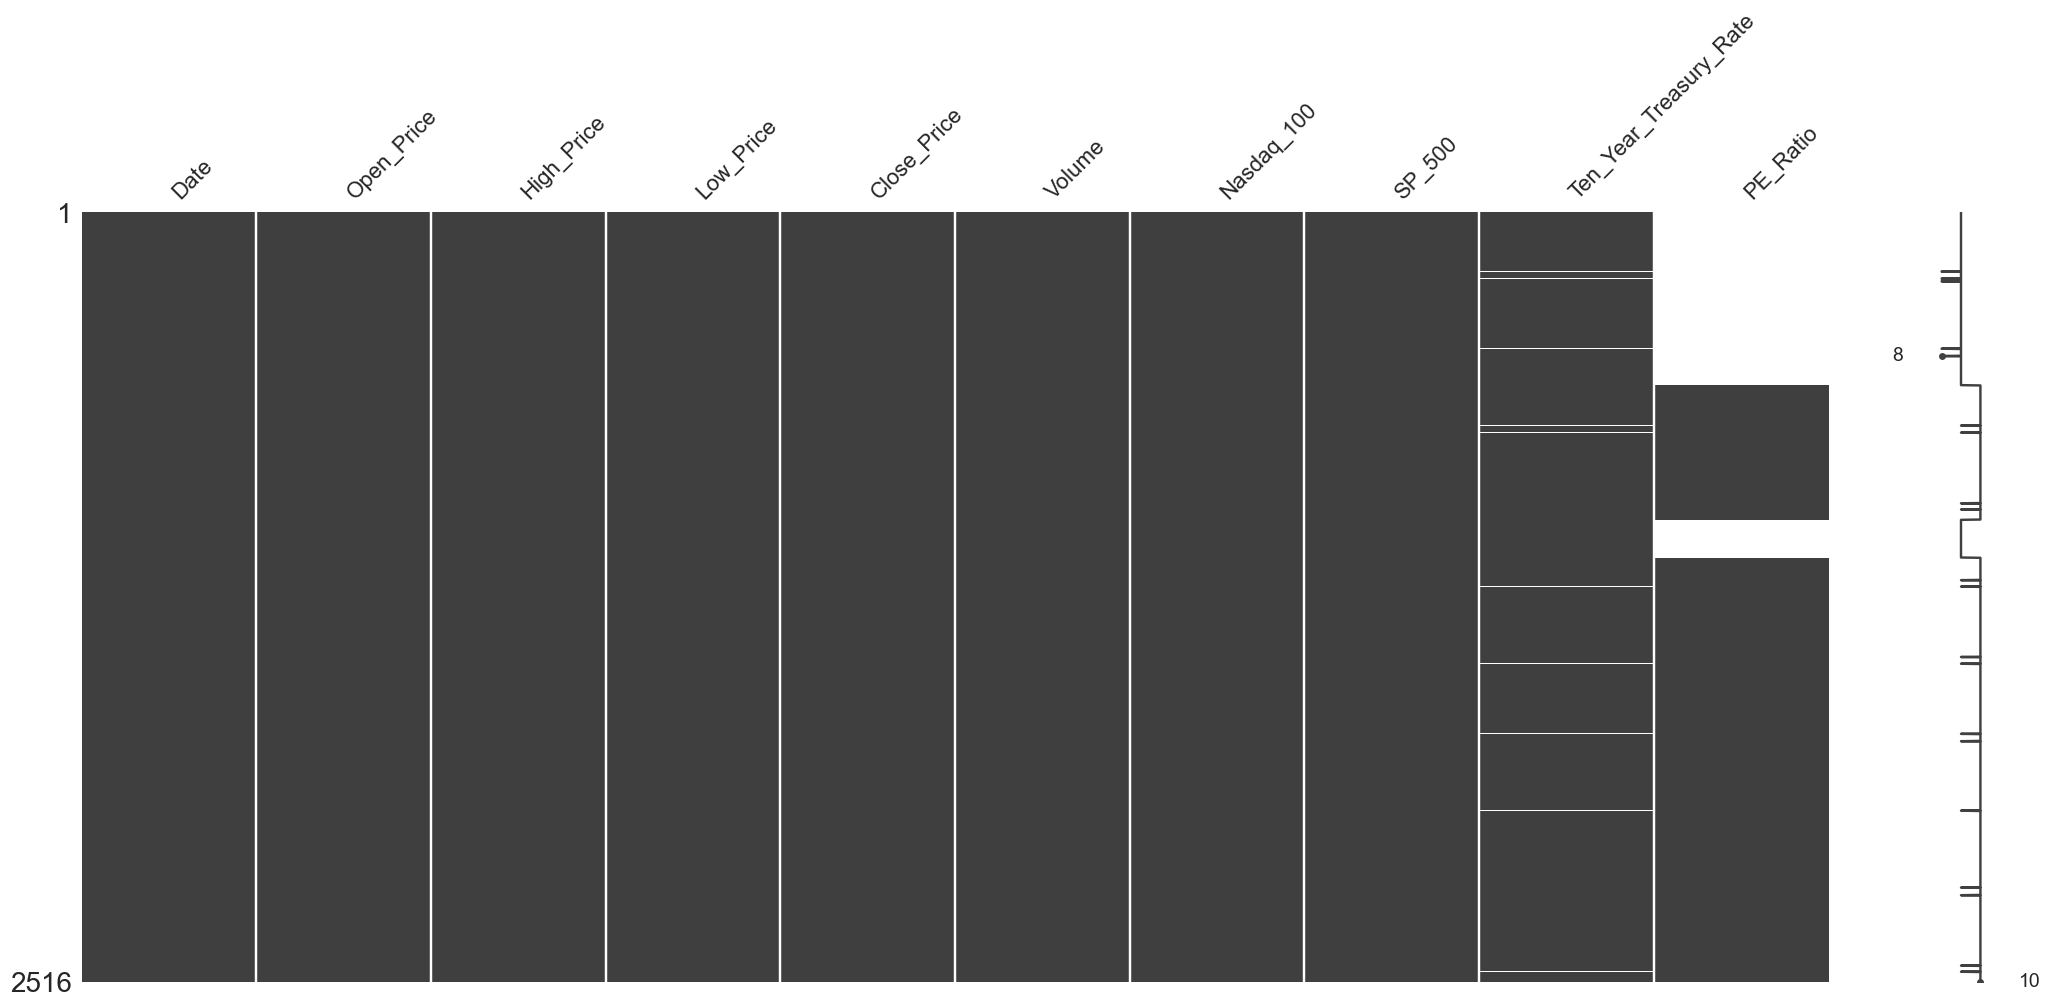

In [6]:
msno.matrix(orig_dt)

### Drop features we do not need

In [7]:
orig_dt[['Next_Day_Close_Price']] = orig_dt[['Close_Price']].shift(-1)
# Delete the last day since we do not have a response
orig_dt.drop(orig_dt.tail(1).index,inplace=True)

In [8]:
price_dt = orig_dt[['High_Price', 'Low_Price', 'Open_Price']]
orig_dt.drop(columns=['Open_Price', 'Low_Price', 'High_Price'], inplace=True)

/var/folders/1q/yryhdjv12lq5rmjvjqdbp0pw0000gn/T/ipykernel_27740/1077718611.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(orig_dt.corr(), annot=True, cmap='coolwarm')


<AxesSubplot: >

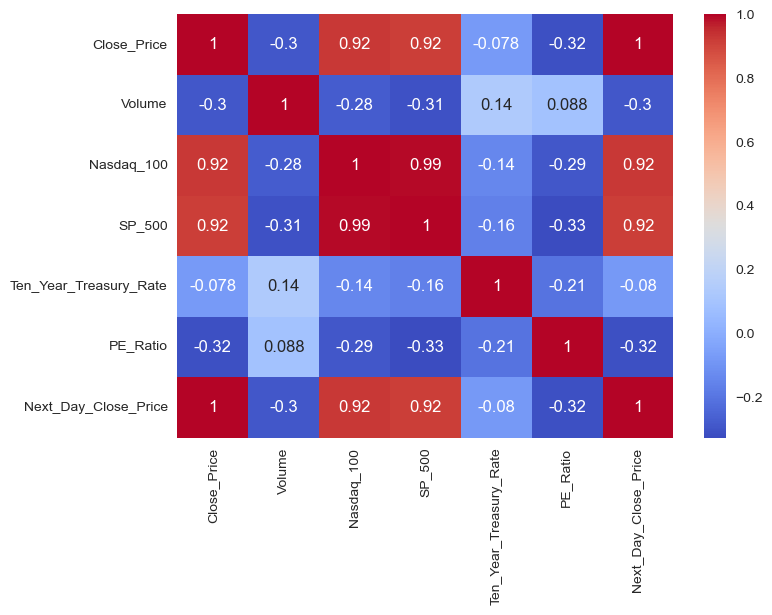

In [9]:
sns.heatmap(orig_dt.corr(), annot=True, cmap='coolwarm')

In [10]:
orig_dt.isna().sum()
orig_dt.dtypes

Date                        0
Close_Price                 0
Volume                      0
Nasdaq_100                  1
SP_500                      0
Ten_Year_Treasury_Rate     19
PE_Ratio                  690
Next_Day_Close_Price        0
dtype: int64

Date                       object
Close_Price               float64
Volume                    float64
Nasdaq_100                float64
SP_500                    float64
Ten_Year_Treasury_Rate    float64
PE_Ratio                  float64
Next_Day_Close_Price      float64
dtype: object

### Convert Date as day before today

In [11]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta



orig_dt['Date'] = pd.to_datetime (orig_dt['Date'])
# Calculate number of days before today's date
today = datetime.now()
orig_dt['DaysBeforeToday'] = (today - orig_dt['Date']).dt.days


### Check distribution of features

/var/folders/1q/yryhdjv12lq5rmjvjqdbp0pw0000gn/T/ipykernel_27740/2983740068.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X, fit=norm, ax=axes[0])
/var/folders/1q/yryhdjv12lq5rmjvjqdbp0pw0000gn/T/ipykernel_27740/2983740068.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X, fit=norm, 

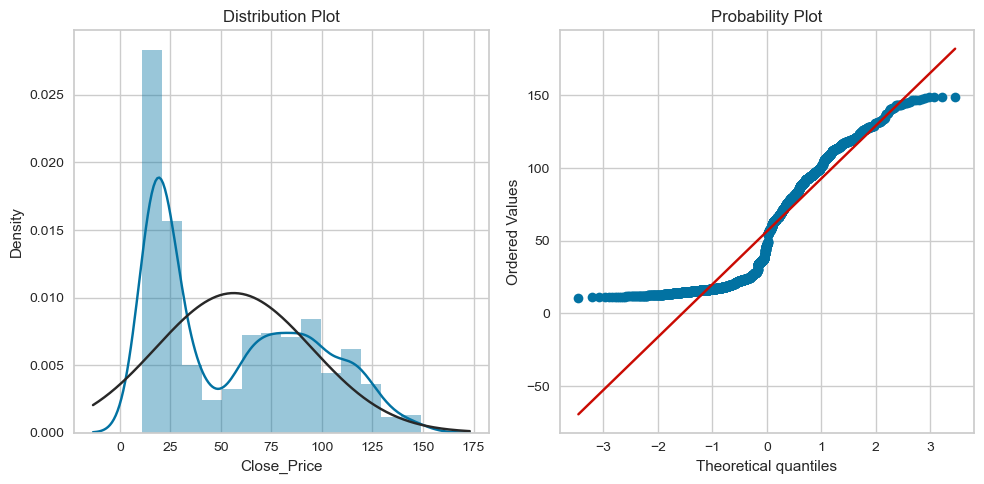

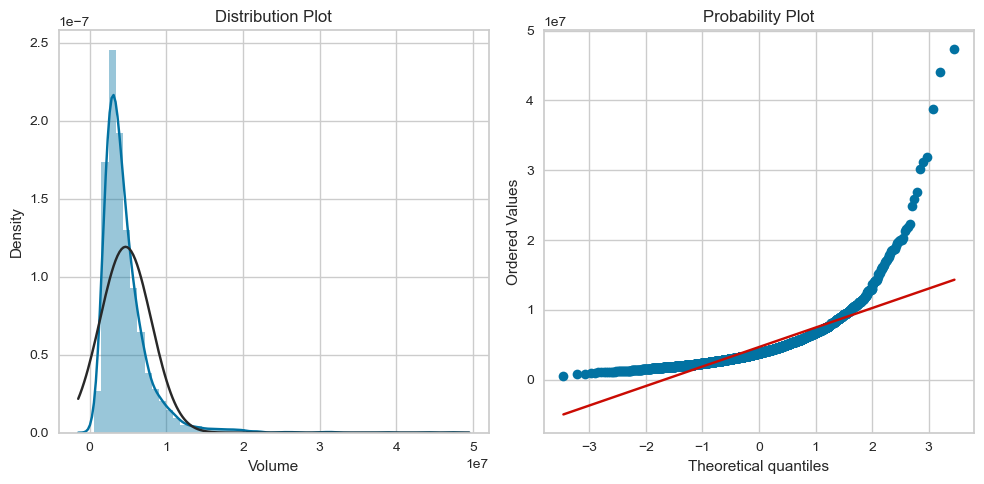

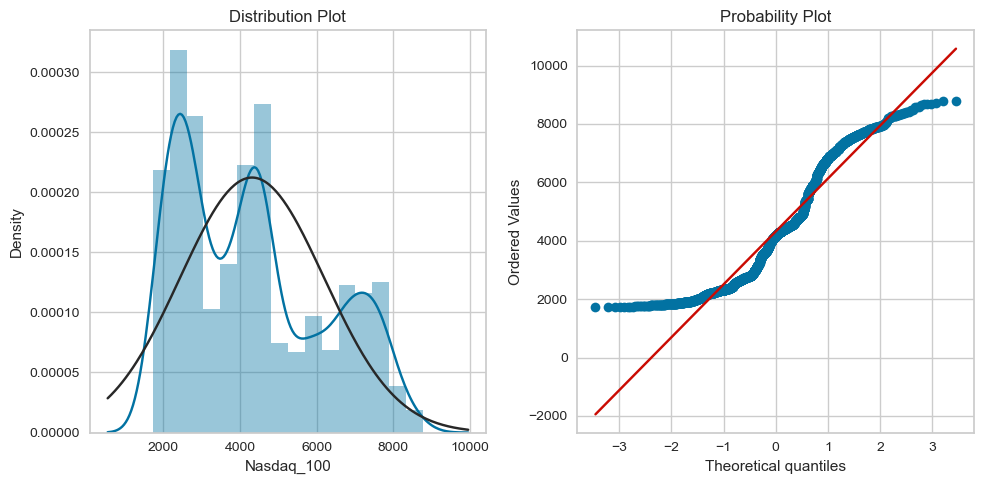

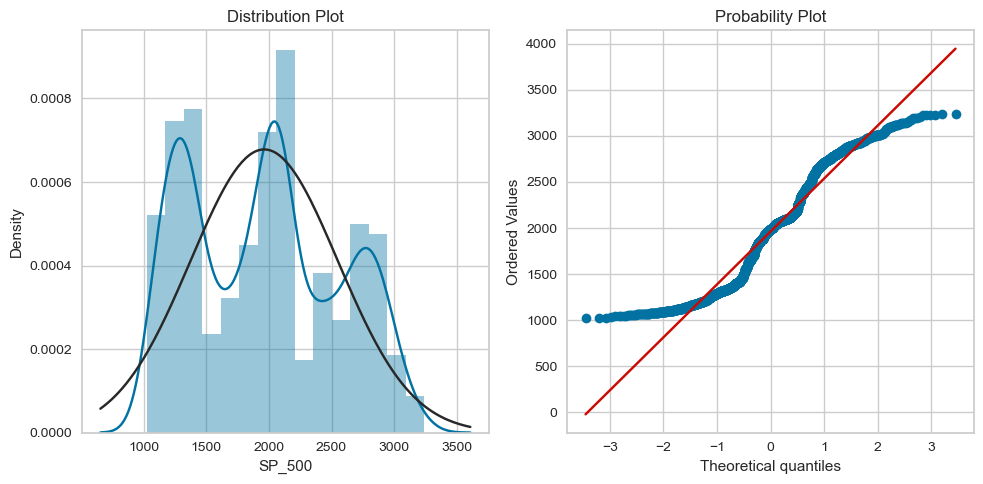

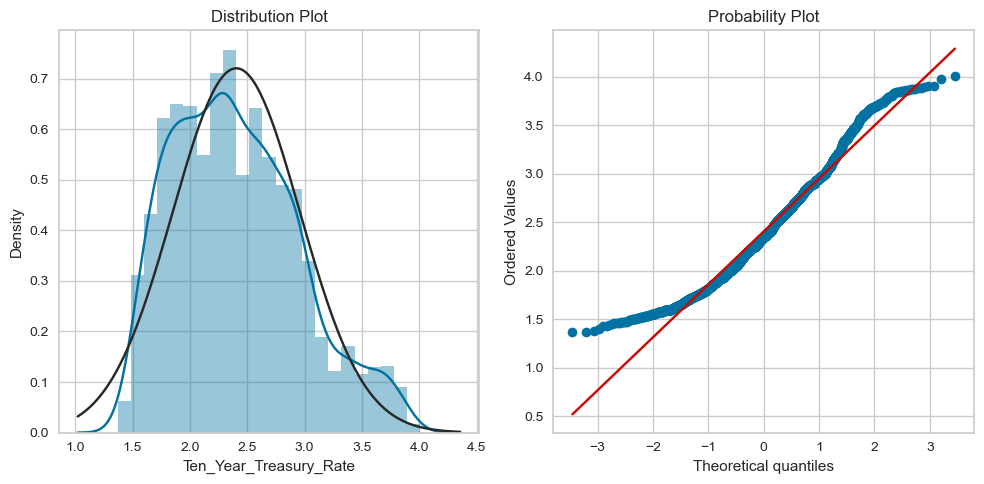

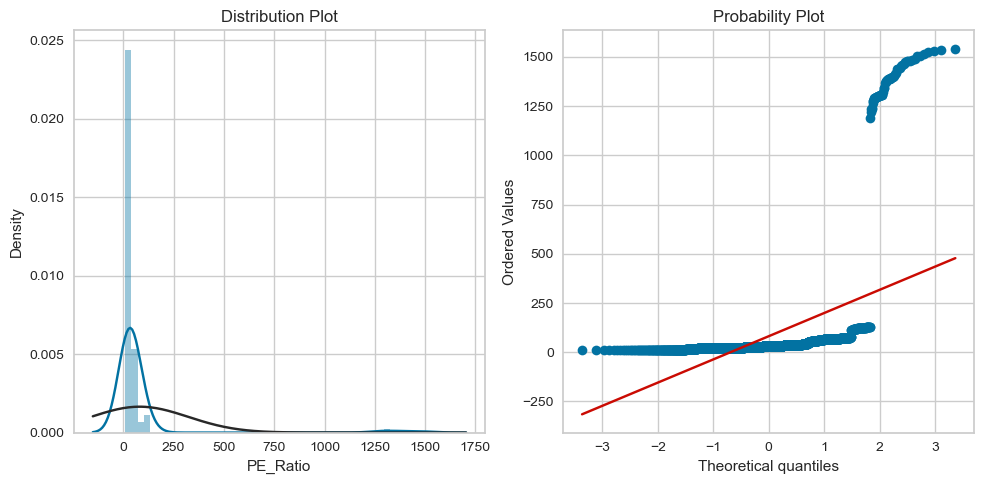

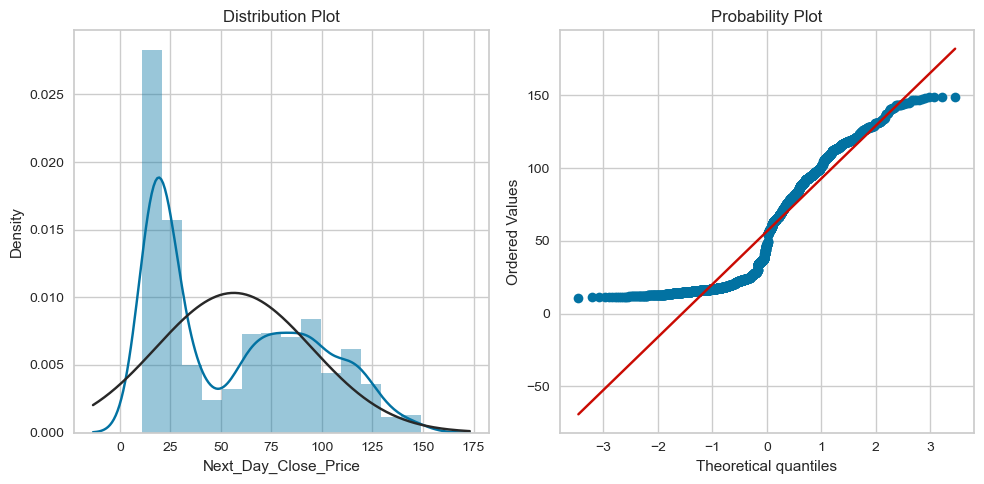

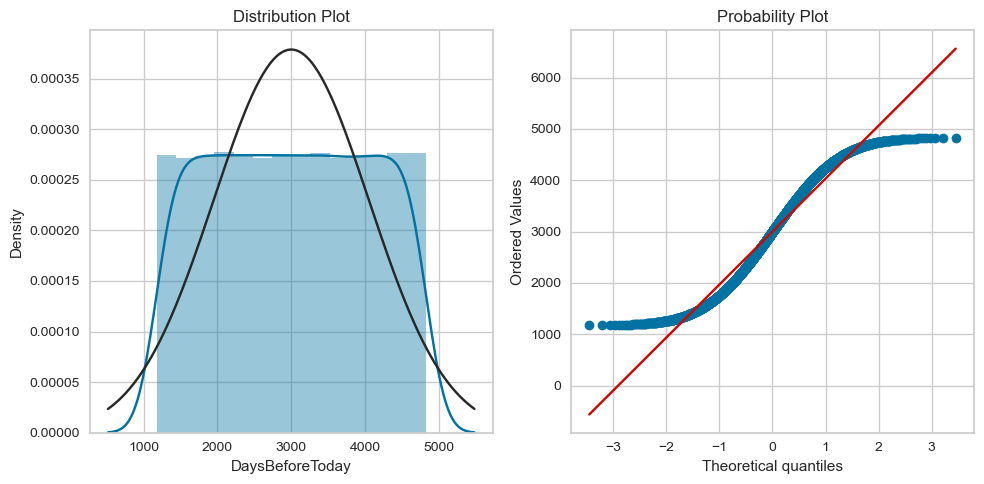

" for col in orig_dt.columns:\n\n\n    plt.scatter(orig_dt[col], orig_dt['DaysBeforeToday'])\n    # add labels to the x and y axes\n    plt.xlabel(col)\n    plt.ylabel('DaysBeforeToday')\n    plt.show()"

Text(0.5, 0, 'Date')

Text(0, 0.5, 'DaysBeforeToday')

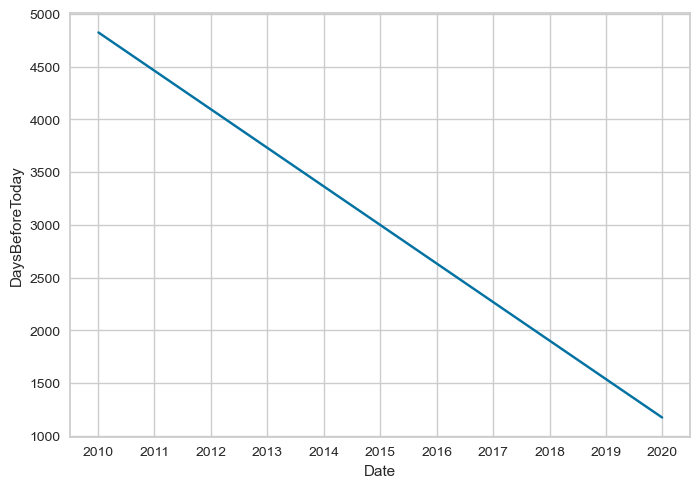

Text(0.5, 0, 'Close_Price')

Text(0, 0.5, 'DaysBeforeToday')

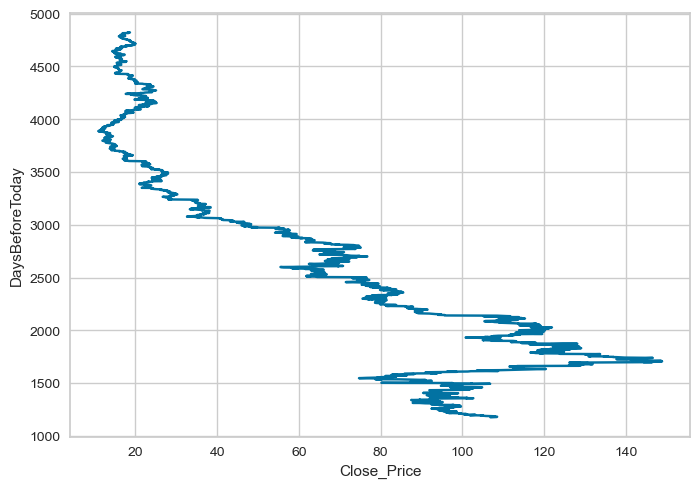

Text(0.5, 0, 'Volume')

Text(0, 0.5, 'DaysBeforeToday')

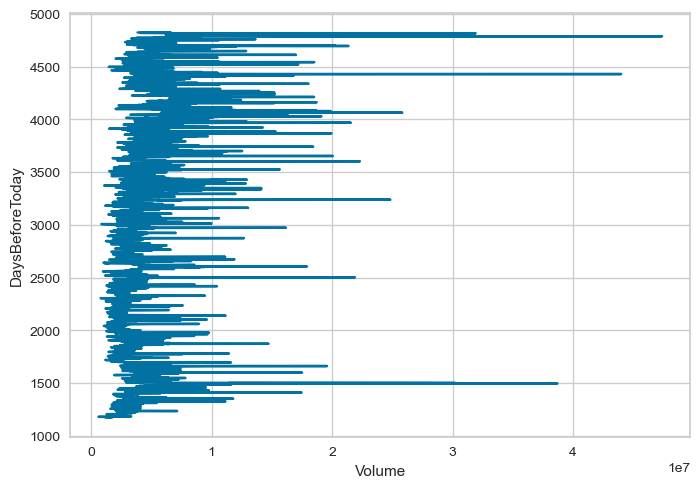

Text(0.5, 0, 'Nasdaq_100')

Text(0, 0.5, 'DaysBeforeToday')

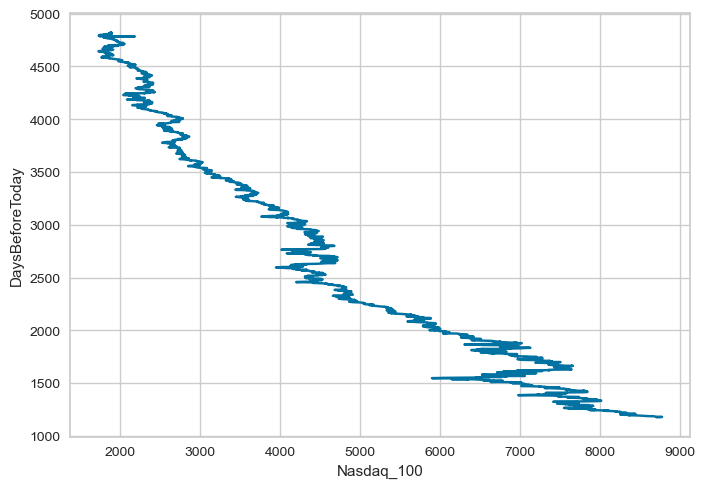

Text(0.5, 0, 'SP_500')

Text(0, 0.5, 'DaysBeforeToday')

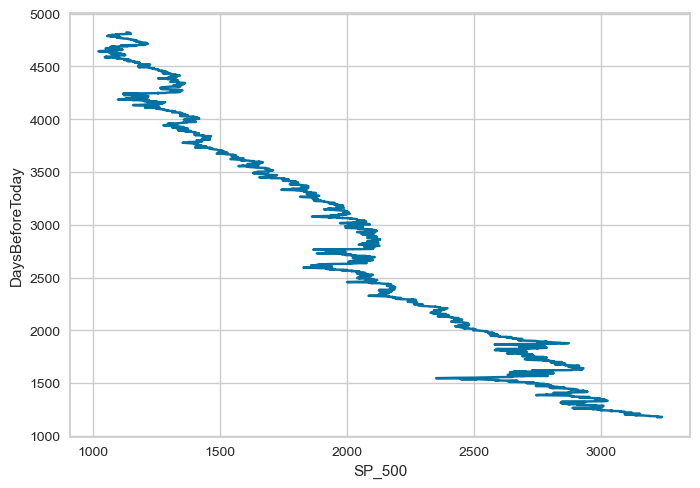

Text(0.5, 0, 'Ten_Year_Treasury_Rate')

Text(0, 0.5, 'DaysBeforeToday')

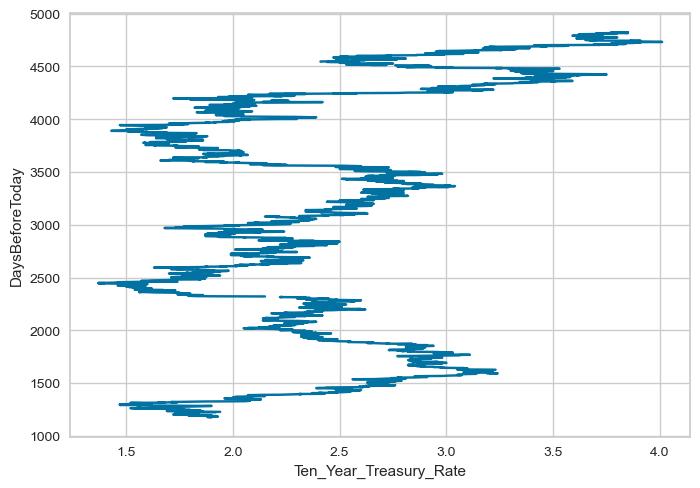

Text(0.5, 0, 'PE_Ratio')

Text(0, 0.5, 'DaysBeforeToday')

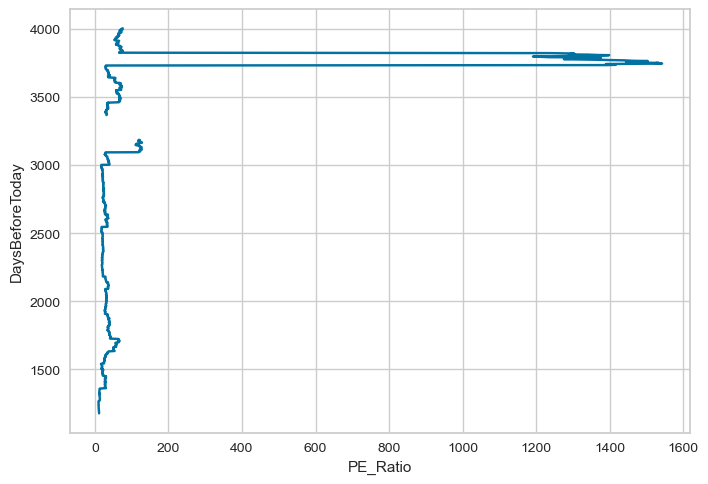

Text(0.5, 0, 'Next_Day_Close_Price')

Text(0, 0.5, 'DaysBeforeToday')

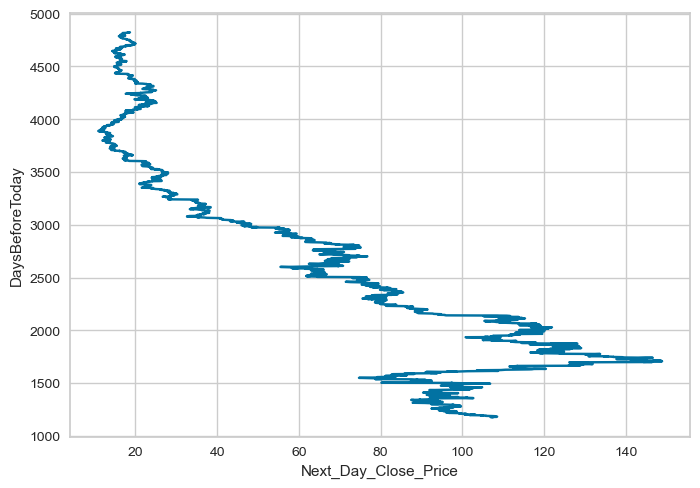

Text(0.5, 0, 'DaysBeforeToday')

Text(0, 0.5, 'DaysBeforeToday')

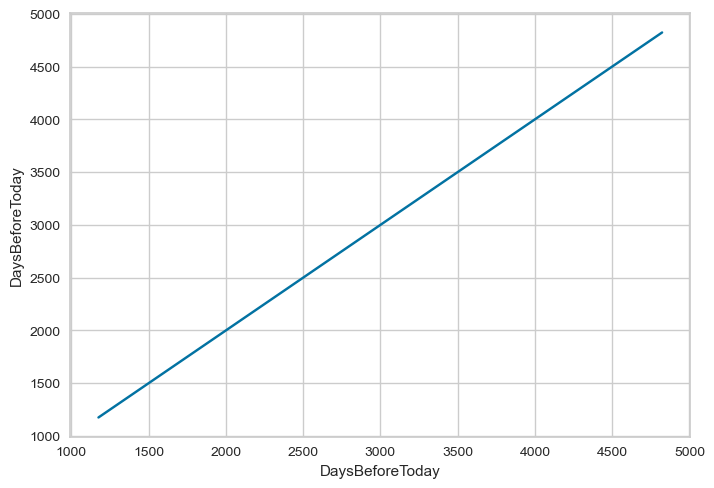

In [12]:
from scipy.stats import norm

def normality_plot(X):
    """
    1. Draw distribution plot with normal distribution fitted curve
    2. Draw Quantile-Quantile plot 
    """
    fig, axes = plt.subplots(1,2, figsize=(10, 5))

    sns.distplot(X, fit=norm, ax=axes[0])
    axes[0].set_title('Distribution Plot')

    axes[1] = stats.probplot((X), plot=plt)
    plt.tight_layout()
# Fit normal distributions to the columns and plot them
for col in orig_dt.columns:
    if col == 'Date':
        continue
    normality_plot(orig_dt[col].dropna())

plt.legend()
plt.show()
''' for col in orig_dt.columns:


    plt.scatter(orig_dt[col], orig_dt['DaysBeforeToday'])
    # add labels to the x and y axes
    plt.xlabel(col)
    plt.ylabel('DaysBeforeToday')
    plt.show()'''
for col in orig_dt.columns:
    plt.plot(orig_dt[col], orig_dt['DaysBeforeToday'])
    # add labels to the x and y axes
    plt.xlabel(col)
    plt.ylabel('DaysBeforeToday')
    plt.show()



# Use polynomial regression fill the missing nasdaq_100 value

In [13]:
Date_dt = pd.DataFrame(orig_dt['Date'])
orig_dt.drop(columns=['Date'], inplace=True)


In [14]:
orig_dt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
temp = orig_dt[['SP_500', 'Nasdaq_100']]
temp = temp.dropna()
# Generate polynomial features
X = temp[['SP_500']].values
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

# Fit a linear regression model to the polynomial features
y = temp['Nasdaq_100'].values
reg = LinearRegression().fit(X_poly, y)

# Predict the missing values in Nasdaq_100
col2_pred = reg.predict(poly.transform(orig_dt[orig_dt['Nasdaq_100'].isna()]['SP_500'].values.reshape(-1, 1)))
orig_dt.loc[orig_dt['Nasdaq_100'].isna(), 'Nasdaq_100'] = col2_pred



,Close_Price,Volume,Nasdaq_100,SP_500,Ten_Year_Treasury_Rate,PE_Ratio,Next_Day_Close_Price,DaysBeforeToday
3,18.15,3853582.0,1886.7000,1132.985478,3.85,NaN,18.66,4823
4,18.66,6632992.0,1888.4300,1136.523386,3.77,NaN,18.18,4822
5,18.18,5047203.0,1878.4200,1137.137830,3.85,NaN,18.04,4821
6,18.04,5437890.0,1876.7200,1141.694928,3.85,NaN,18.40,4820
7,18.40,4055760.0,1892.5900,1144.983058,3.83,NaN,18.27,4819
...,...,...,...,...,...,...,...,...
3643,107.79,1622621.0,8696.0072,3224.009886,1.93,11.7291,108.55,1183
3644,108.55,606064.0,8699.5055,3223.375700,1.90,11.8118,108.51,1182
3646,108.51,1676723.0,8778.3138,3239.907138,1.90,11.8074,108.43,1180
3647,108.43,1163444.0,8770.9791,3240.020358,1.88,11.7987,106.93,1179


# Using linear regression filled out the 10_year_treasury

In [15]:
miss_some = orig_dt.assign( Ten_Year_Treasury_Rate = orig_dt['Ten_Year_Treasury_Rate'].interpolate(method='linear'))

In [16]:
miss_some.dtypes

Close_Price               float64
Volume                    float64
Nasdaq_100                float64
SP_500                    float64
Ten_Year_Treasury_Rate    float64
PE_Ratio                  float64
Next_Day_Close_Price      float64
DaysBeforeToday             int64
dtype: object

# Using deep learning to fill the missing PE values

In [17]:
miss_some.isna().sum()

Close_Price                 0
Volume                      0
Nasdaq_100                  0
SP_500                      0
Ten_Year_Treasury_Rate      0
PE_Ratio                  690
Next_Day_Close_Price        0
DaysBeforeToday             0
dtype: int64

In [18]:
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta

train = miss_some[miss_some['PE_Ratio'].notna()]
test = miss_some[miss_some['PE_Ratio'].isna()]
X_train = train.drop(columns=['PE_Ratio', 'Close_Price'])
y_train = train[["PE_Ratio"]]
X_test = test.drop(columns=['PE_Ratio', 'Close_Price'])
sc = StandardScaler()
X_train = sc.fit_transform(X_train.values)
X_test = sc.transform(X_test.values)


In [19]:
train

,Close_Price,Volume,Nasdaq_100,SP_500,Ten_Year_Treasury_Rate,PE_Ratio,Next_Day_Close_Price,DaysBeforeToday
822,16.71,4286702.0,2784.4200,1419.043790,2.22,75.9545,16.65,4004
823,16.65,5752780.0,2782.7800,1413.380591,2.30,75.6818,16.26,4003
824,16.26,3841361.0,2745.0000,1398.958581,2.25,73.9091,16.27,4002
825,16.27,3734548.0,2762.5000,1398.084146,2.19,73.9545,15.90,4001
829,15.90,4750726.0,2739.9800,1382.202137,2.06,72.2727,15.55,3997
...,...,...,...,...,...,...,...,...
3643,107.79,1622621.0,8696.0072,3224.009886,1.93,11.7291,108.55,1183
3644,108.55,606064.0,8699.5055,3223.375700,1.90,11.8118,108.51,1182
3646,108.51,1676723.0,8778.3138,3239.907138,1.90,11.8074,108.43,1180
3647,108.43,1163444.0,8770.9791,3240.020358,1.88,11.7987,106.93,1179


In [20]:
''' from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
import math 
estimator = KNeighborsRegressor(n_neighbors=round(math.sqrt(2011)), weights='distance')
estimator.fit(X_train, y_train)
prediction = estimator.predict(X_test)
test['PE_Ratio'] = prediction
miss_some['PE_Ratio'].fillna(test['PE_Ratio'], inplace=True)
miss_some.isna().sum() '''

" from sklearn.preprocessing import StandardScaler\nfrom sklearn.neighbors import KNeighborsRegressor\nimport math \nestimator = KNeighborsRegressor(n_neighbors=round(math.sqrt(2011)), weights='distance')\nestimator.fit(X_train, y_train)\nprediction = estimator.predict(X_test)\ntest['PE_Ratio'] = prediction\nmiss_some['PE_Ratio'].fillna(test['PE_Ratio'], inplace=True)\nmiss_some.isna().sum() "

In [21]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
# define base model
def baseline_model_simple():
    # create model
    model = Sequential()
    model.add(Dense(units=6, kernel_initializer='normal', activation='relu'))
    model.add(Dense(units=12, kernel_initializer = 'uniform', activation = 'relu'))
    model.add(Dense(units=12, kernel_initializer = 'uniform', activation = 'relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
# Fitting to the training set
estimator = KerasRegressor(build_fn=baseline_model_simple, epochs=250, batch_size=500, verbose=0)
estimator.fit(X_train, y_train)
# Predicting the results
prediction = estimator.predict(X_test)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-03-20 01:43:04.824098: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-20 01:43:04.824559: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-03-20 01:43:04.995218: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-20 01:43:05.278412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2023-03-20 01:43:10.365763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [22]:
prediction0 = prediction
prediction0 = prediction0.tolist()
prediction0

[134.650146484375,
 151.5638427734375,
 138.73399353027344,
 139.3512420654297,
 136.38722229003906,
 142.0601348876953,
 246.3024444580078,
 174.49520874023438,
 160.45416259765625,
 169.50494384765625,
 157.932373046875,
 166.01416015625,
 192.4454345703125,
 180.51458740234375,
 171.75067138671875,
 167.49996948242188,
 182.9413299560547,
 189.75482177734375,
 177.50247192382812,
 166.59043884277344,
 171.3262939453125,
 159.7103271484375,
 177.5824737548828,
 191.42559814453125,
 211.79855346679688,
 318.09344482421875,
 189.8648681640625,
 169.58895874023438,
 164.63348388671875,
 170.16415405273438,
 166.86207580566406,
 147.9969482421875,
 161.0405731201172,
 154.38502502441406,
 160.86961364746094,
 152.44595336914062,
 167.70645141601562,
 167.86575317382812,
 166.85427856445312,
 165.73626708984375,
 155.67718505859375,
 160.7511749267578,
 153.67274475097656,
 153.0883026123047,
 179.01223754882812,
 154.13905334472656,
 150.1798858642578,
 146.684326171875,
 143.83882141113

In [23]:
miss_some['PE_GIVEN_TAG'] = [0] * miss_some.shape[0]
for index, row in miss_some.iterrows():
    if not np.isnan(row['PE_Ratio']):
        miss_some.at[index,'PE_GIVEN_TAG'] = 1
        continue
    miss_some.at[index,'PE_Ratio'] = prediction0.pop(0)
        

### Visualize the data

In [24]:
miss_some.isna().sum()

Close_Price               0
Volume                    0
Nasdaq_100                0
SP_500                    0
Ten_Year_Treasury_Rate    0
PE_Ratio                  0
Next_Day_Close_Price      0
DaysBeforeToday           0
PE_GIVEN_TAG              0
dtype: int64

<AxesSubplot: >

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


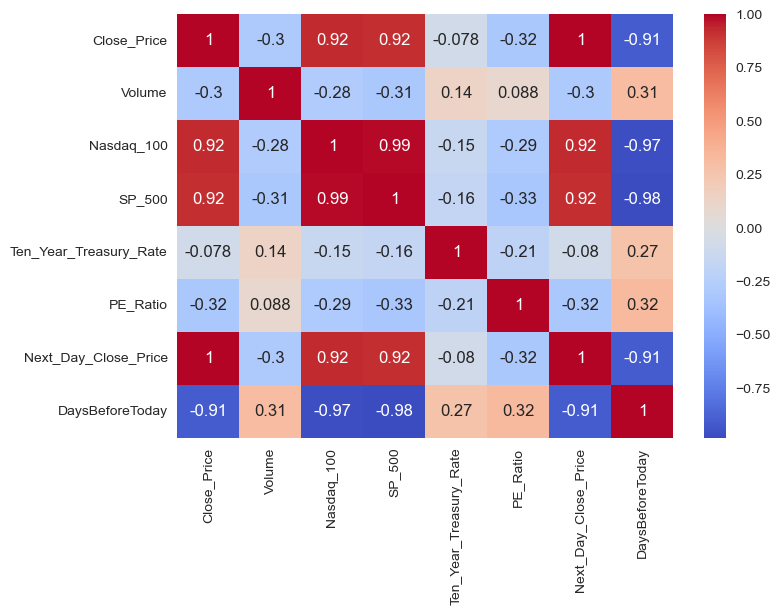

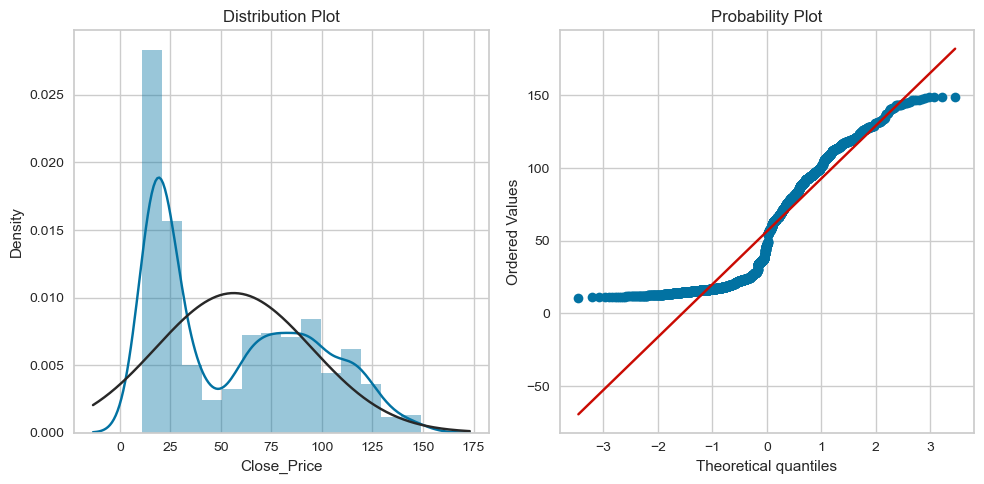

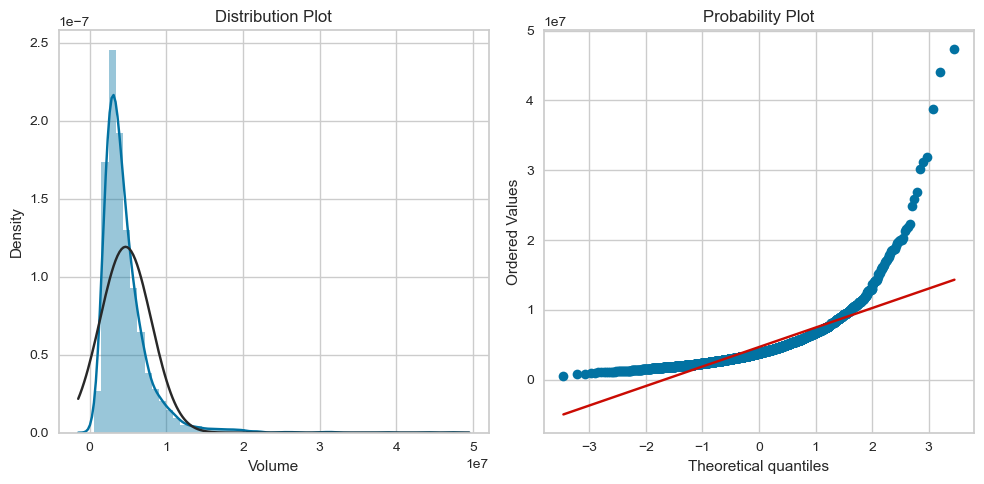

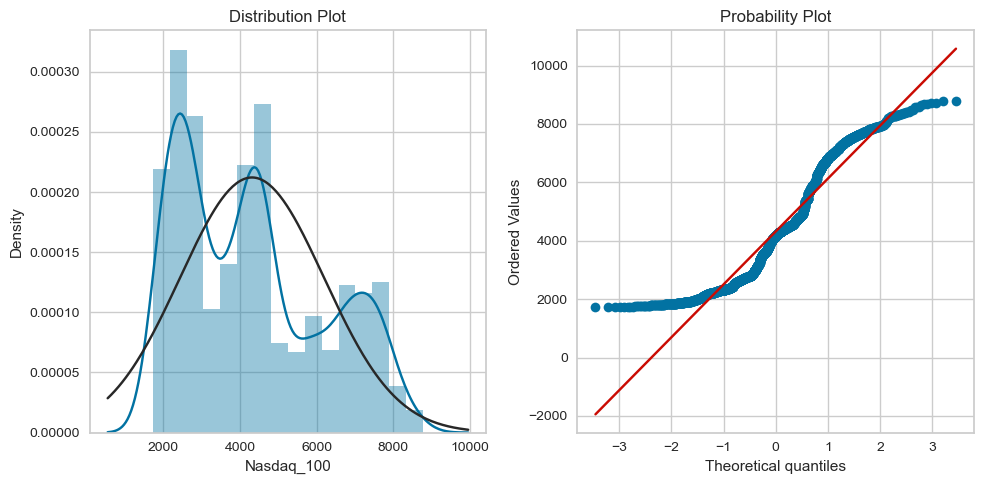

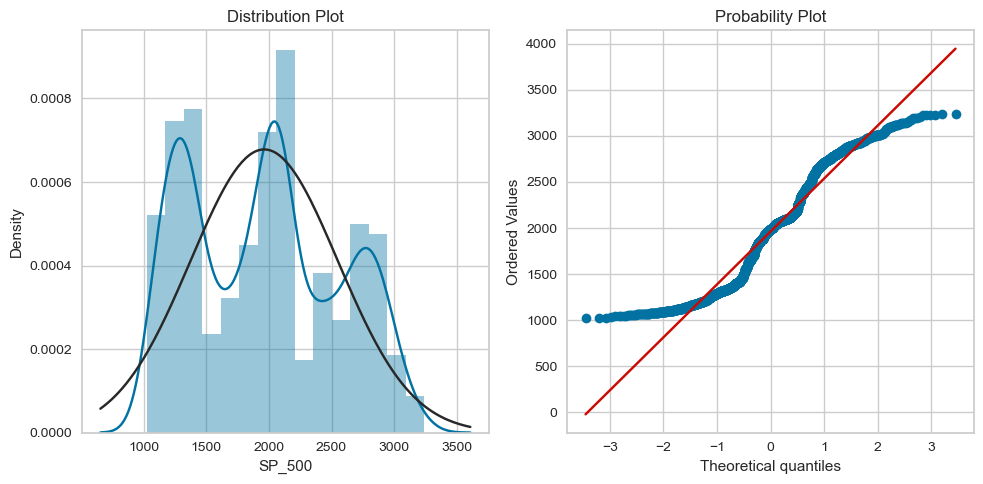

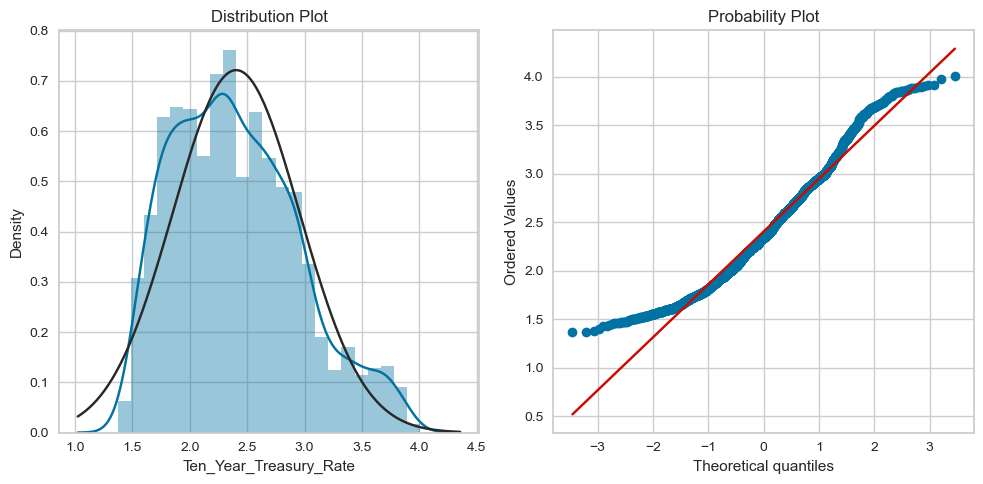

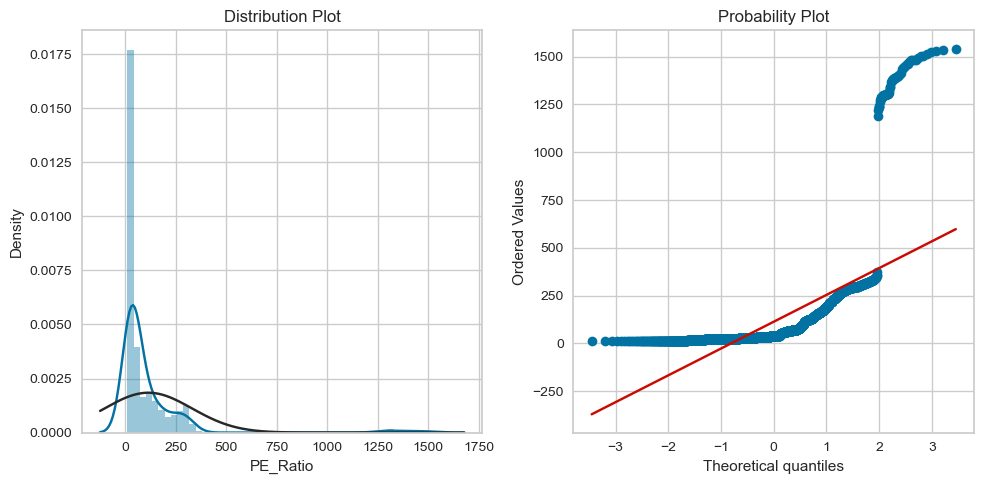

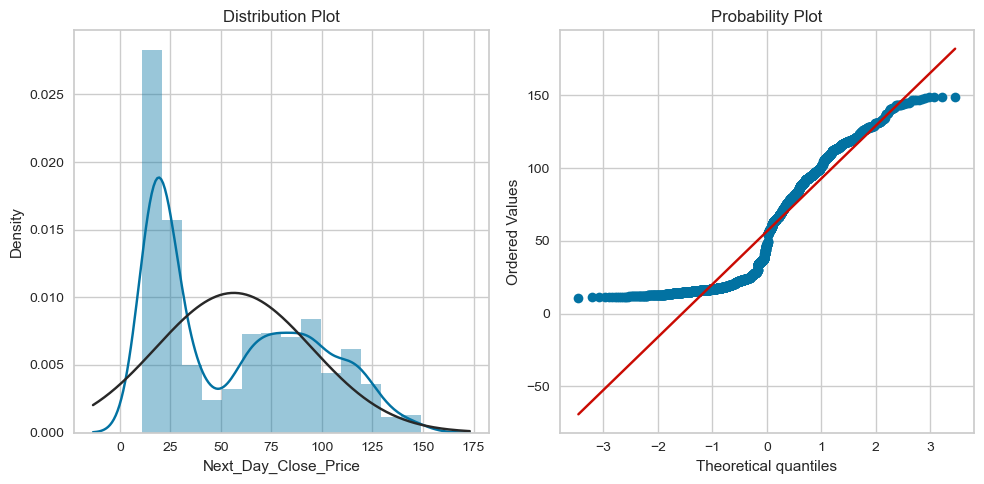

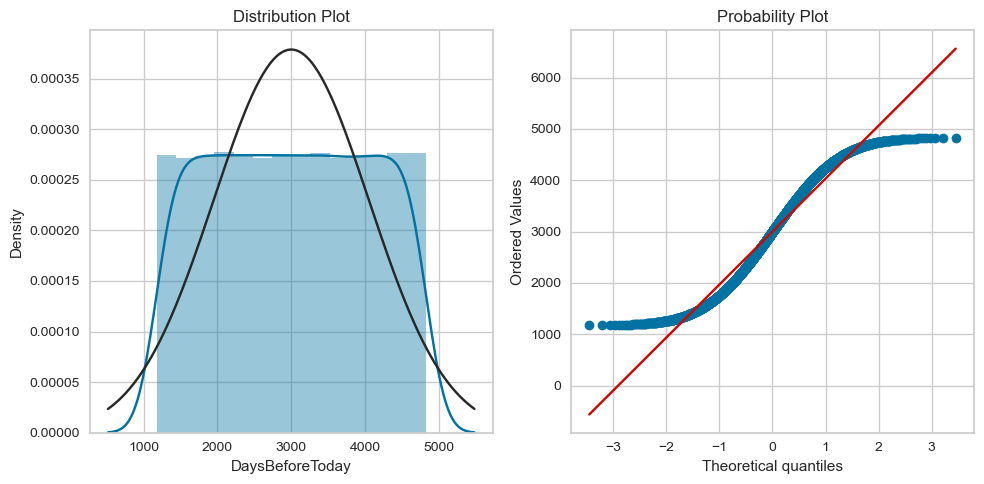

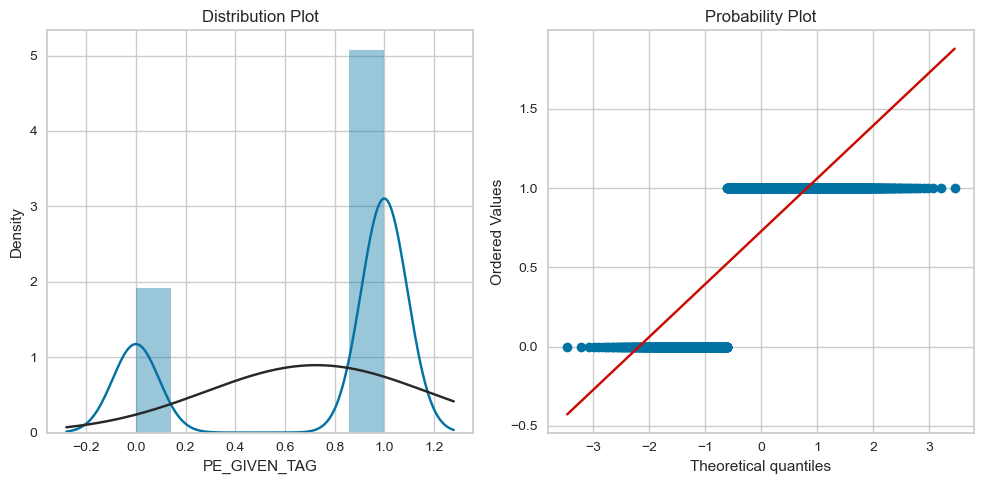

" for col in miss_some.columns:\n    plt.scatter(miss_some[col], miss_some['DaysBeforeToday'])\n    # add labels to the x and y axes\n    plt.xlabel(col)\n    plt.ylabel('DaysBeforeToday ')\n    plt.show() "

Text(0.5, 0, 'Close_Price')

Text(0, 0.5, 'DaysBeforeToday')

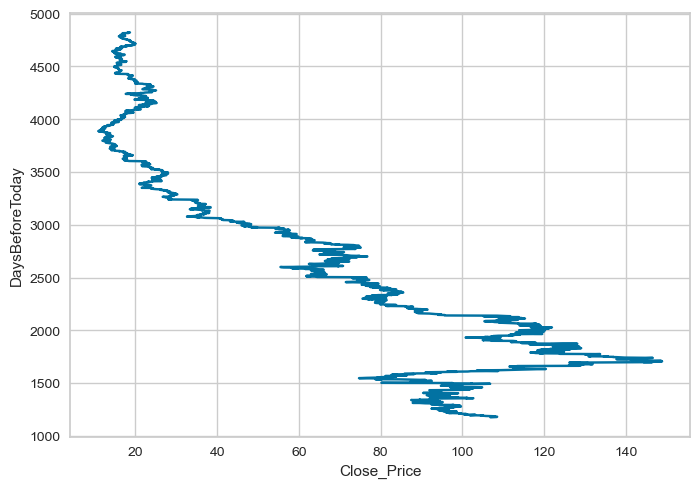

Text(0.5, 0, 'Volume')

Text(0, 0.5, 'DaysBeforeToday')

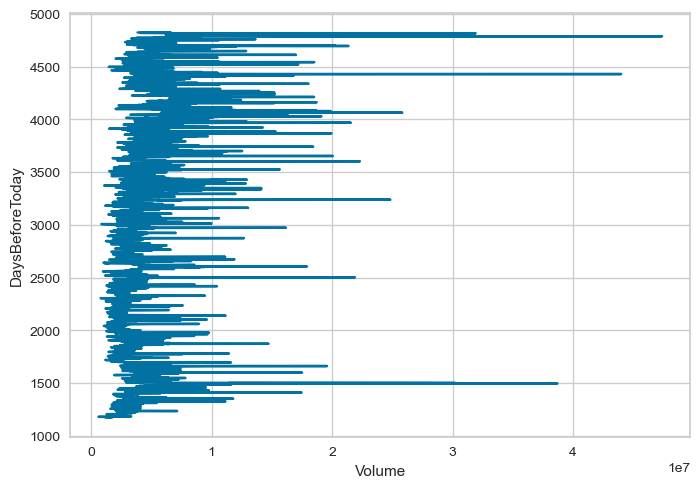

Text(0.5, 0, 'Nasdaq_100')

Text(0, 0.5, 'DaysBeforeToday')

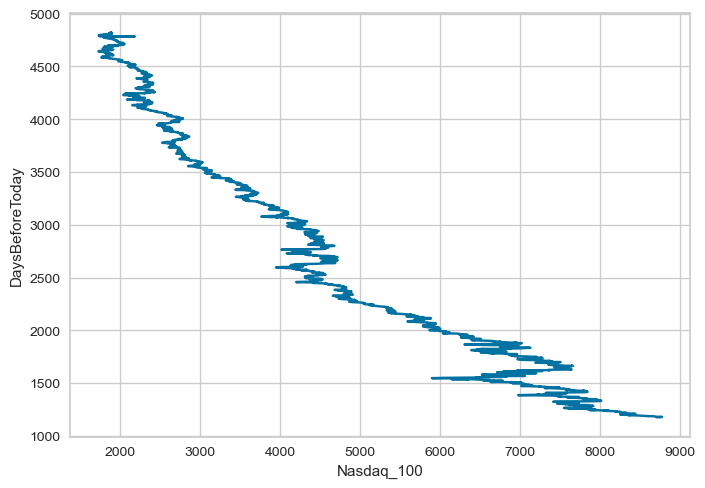

Text(0.5, 0, 'SP_500')

Text(0, 0.5, 'DaysBeforeToday')

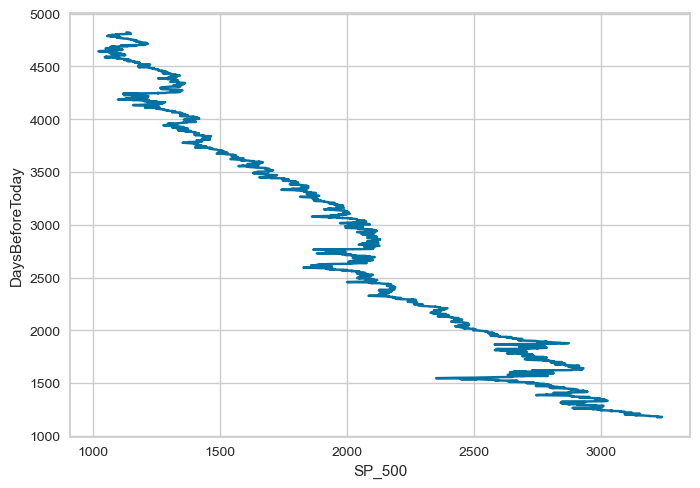

Text(0.5, 0, 'Ten_Year_Treasury_Rate')

Text(0, 0.5, 'DaysBeforeToday')

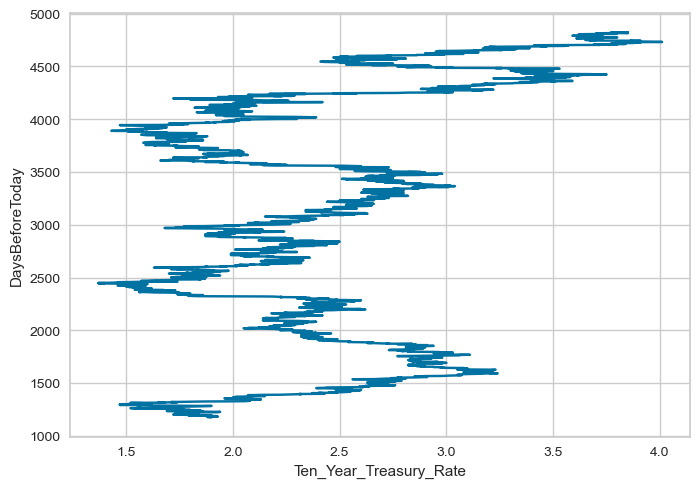

Text(0.5, 0, 'PE_Ratio')

Text(0, 0.5, 'DaysBeforeToday')

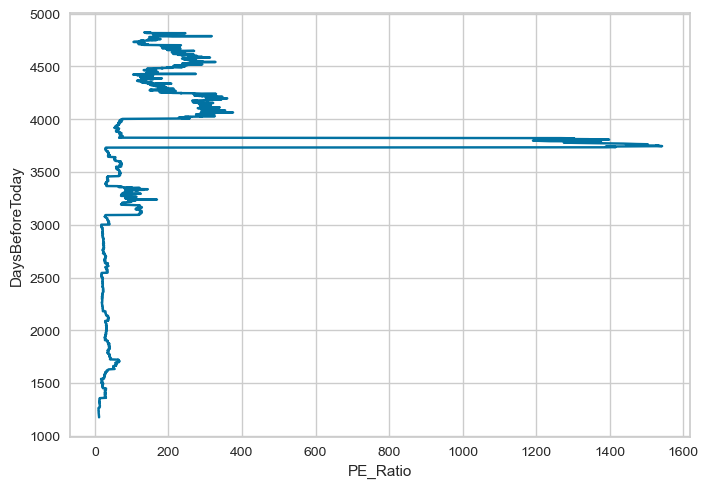

Text(0.5, 0, 'Next_Day_Close_Price')

Text(0, 0.5, 'DaysBeforeToday')

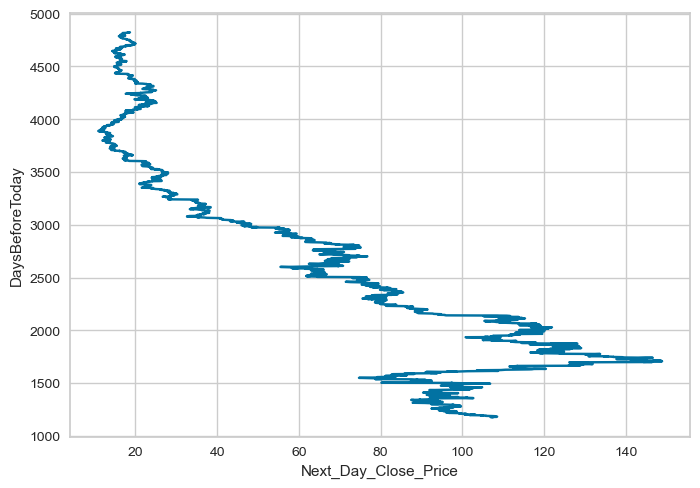

Text(0.5, 0, 'DaysBeforeToday')

Text(0, 0.5, 'DaysBeforeToday')

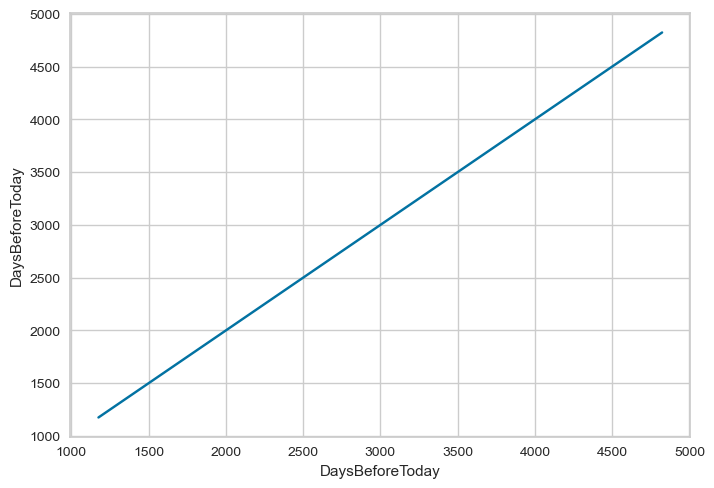

Text(0.5, 0, 'PE_GIVEN_TAG')

Text(0, 0.5, 'DaysBeforeToday')

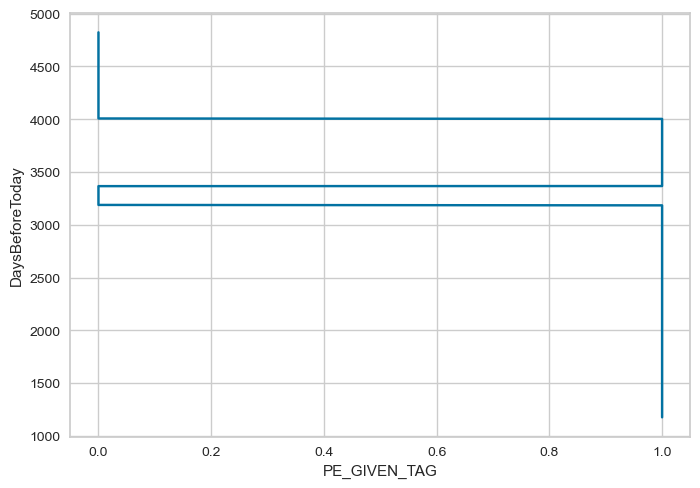

In [25]:
sns.heatmap(orig_dt.corr(), annot=True, cmap='coolwarm')
def normality_plot(X):
    """
    1. Draw distribution plot with normal distribution fitted curve
    2. Draw Quantile-Quantile plot 
    """
    fig, axes = plt.subplots(1,2, figsize=(10, 5))

    sns.distplot(X, fit=norm, ax=axes[0])
    axes[0].set_title('Distribution Plot')

    axes[1] = stats.probplot((X), plot=plt)
    plt.tight_layout()
# Fit normal distributions to the columns and plot them
for col in miss_some.columns:
    normality_plot(miss_some[col])
    # create the scatter plot


plt.legend()
plt.show()


''' for col in miss_some.columns:
    plt.scatter(miss_some[col], miss_some['DaysBeforeToday'])
    # add labels to the x and y axes
    plt.xlabel(col)
    plt.ylabel('DaysBeforeToday ')
    plt.show() '''
for col in miss_some.columns:
    plt.plot(miss_some[col], miss_some['DaysBeforeToday'])
    # add labels to the x and y axes
    plt.xlabel(col)
    plt.ylabel('DaysBeforeToday')
    plt.show()

    

In [26]:
data_filled = miss_some

### Save back

In [27]:
data_filled.to_csv("EA_CLEAN/ea_cleaned_data.csv", index=False)

In [28]:
def get_season_dt(date, key, season_dt):
    quarter = (date.month - 1) // 3 * 3 + 3
    return season_dt.loc[(season_dt['Date'].dt.year == date.year) & (season_dt['Date'].dt.month == quarter), key].values[0]

In [29]:
def get_last_day_of_quarter(year, quarter):
    if quarter == 3:
        last_day = datetime(year, 3, 31)
    elif quarter == 6:
        last_day = datetime(year, 6, 30)
    elif quarter == 9:
        last_day = datetime(year, 9, 30)
    else:
        last_day = datetime(year, 12, 31)
    return last_day

In [30]:
def day_in_season(date):
    quarter = (date.month - 1) // 3 * 3 + 3
    quarter_start = get_last_day_of_quarter(date.year, quarter)
    return (quarter_start - date).days

In [31]:
roa = pd.read_csv('EA_data/ea_return_on_assets_data.csv')
Date_dt = pd.DataFrame(Date_dt)
Date_dt['Date'] = pd.to_datetime(Date_dt['Date'])
roa['Period'] = pd.to_datetime(roa['Period'])
roa.columns = ['Date', 'ROA']

In [32]:
Date_dt['ROA'] = Date_dt['Date'].map(lambda x: get_season_dt(x, 'ROA', roa))

In [33]:
gdp = pd.read_csv('USRGDP.csv')
gdp.columns = ['Date', 'GDP']
gdp['Date'] = pd.to_datetime(gdp['Date'])

In [34]:
Date_dt['GDP'] = Date_dt['Date'].map(lambda x: get_season_dt(x, 'GDP', gdp))

In [35]:
Date_dt['Day_Before_Next_Season'] = Date_dt['Date'].map(lambda x : day_in_season(x))

In [36]:
data_filled = pd.concat([data_filled, Date_dt], axis=1)
data_filled = pd.concat([data_filled, price_dt], axis=1)
data_filled

,Close_Price,Volume,Nasdaq_100,SP_500,Ten_Year_Treasury_Rate,PE_Ratio,Next_Day_Close_Price,DaysBeforeToday,PE_GIVEN_TAG,Date,ROA,GDP,Day_Before_Next_Season,High_Price,Low_Price,Open_Price
3,18.15,3853582.0,1886.7000,1132.985478,3.85,134.650146,18.66,4823,0,2010-01-04,-14.1118,1.5,86,18.235001,17.89,17.95
4,18.66,6632992.0,1888.4300,1136.523386,3.77,151.563843,18.18,4822,0,2010-01-05,-14.1118,1.5,85,18.870000,18.23,18.30
5,18.18,5047203.0,1878.4200,1137.137830,3.85,138.733994,18.04,4821,0,2010-01-06,-14.1118,1.5,84,18.650000,18.06,18.65
6,18.04,5437890.0,1876.7200,1141.694928,3.85,139.351242,18.40,4820,0,2010-01-07,-14.1118,1.5,83,18.070000,17.78,17.91
7,18.40,4055760.0,1892.5900,1144.983058,3.83,136.387222,18.27,4819,0,2010-01-08,-14.1118,1.5,82,18.450000,18.03,18.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3643,107.79,1622621.0,8696.0072,3224.009886,1.93,11.729100,108.55,1183,1,2019-12-23,28.6919,1.8,8,108.920000,107.67,108.27
3644,108.55,606064.0,8699.5055,3223.375700,1.90,11.811800,108.51,1182,1,2019-12-24,28.6919,1.8,7,108.870000,107.73,107.78
3646,108.51,1676723.0,8778.3138,3239.907138,1.90,11.807400,108.43,1180,1,2019-12-26,28.6919,1.8,5,108.888000,108.11,108.56
3647,108.43,1163444.0,8770.9791,3240.020358,1.88,11.798700,106.93,1179,1,2019-12-27,28.6919,1.8,4,108.890000,107.80,108.60


In [37]:
data_filled.to_csv("filled_EA.csv", index=False)